In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../../../../nathan.mplstyle')

In [2]:
import cymetric as cym
from cymetric import filters 
from cymetric import graphs 
from cymetric import timeseries 
from cymetric import tools
import graphviz
import sqlite3

# Cymetric

In [3]:
db = cym.dbopen('single_xe100_out_simple.sqlite')
evaler = cym.Evaluator(db, write=False)

In [4]:
reactor_list = ['Xe_100_1']

In [5]:
time = evaler.eval('TimeList')
commission_df = evaler.eval('BuildSeries')
decommission_df = evaler.eval('DecommissionSeries')

commission_df = commission_df.rename(index=str, columns={'EnterTime': 'Time'})
commission_df = tools.add_missing_time_step(commission_df, time)
commission_by_prototype = pd.pivot_table(
        commission_df,
        values='Count',
        index='Time',
        columns='Prototype',
        fill_value=0)

In [6]:
decommission_df = decommission_df.rename(index=str, columns={'ExitTime': 'Time'})
decommission_df = tools.add_missing_time_step(decommission_df, time)
decommission_by_prototype = pd.pivot_table(
        commission_df,
        values='Count',
        index='Time',
        columns='Prototype',
        fill_value=0)
negative_count = -decommission_df['Count']
decommission_df = decommission_df.drop('Count', axis=1)
decommission_df = pd.concat([decommission_df, negative_count], axis=1)
decommission_df.rename(columns={'ExitTime': 'Time'}, inplace=True)
decommission_by_prototype = decommission_df.pivot(index='Time', columns='Prototype')['Count'].reset_index()
decommission_by_prototype = decommission_by_prototype.fillna(0)

In [7]:
deployment_by_prototype = commission_by_prototype.copy()

for reactor in reactor_list:
    dep_xe100 = decommission_by_prototype[reactor] + commission_by_prototype[reactor]
    deployment_by_prototype[reactor] = dep_xe100

In [8]:
deployment_by_prototype['Xe_100_total'] = deployment_by_prototype[reactor_list[0]].cumsum()
if len(reactor_list)>1:
    for reactor in reactor_list:
        deployment_by_prototype['Xe_100_total'] += deployment_by_prototype[reactor].cumsum()
else:
    pass

Text(0, 0.5, 'Reactors [#]')

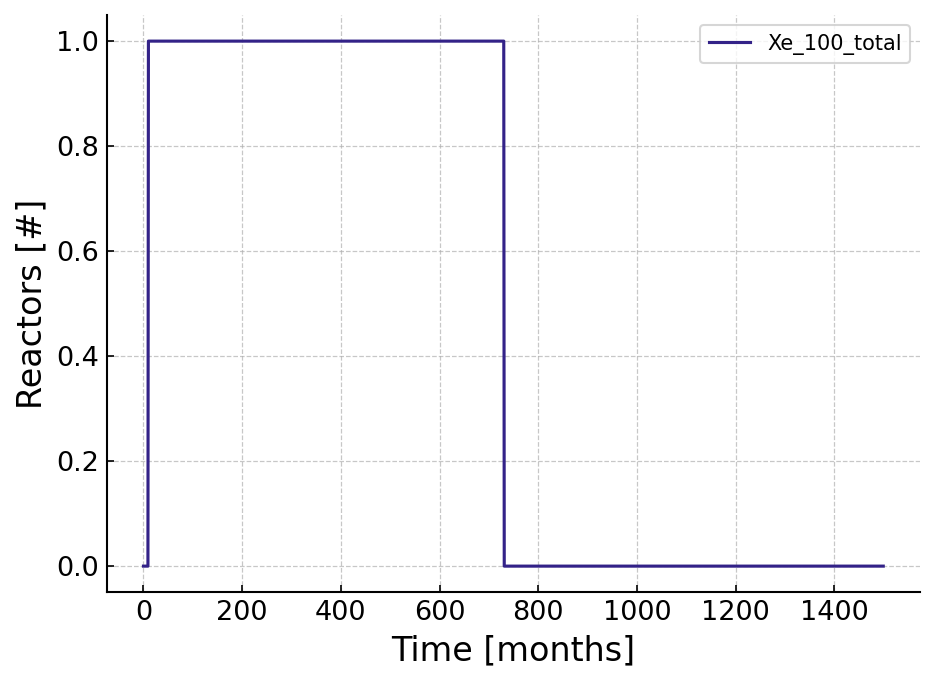

In [9]:
deployment_by_prototype.plot(y='Xe_100_total', use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Reactors [#]')

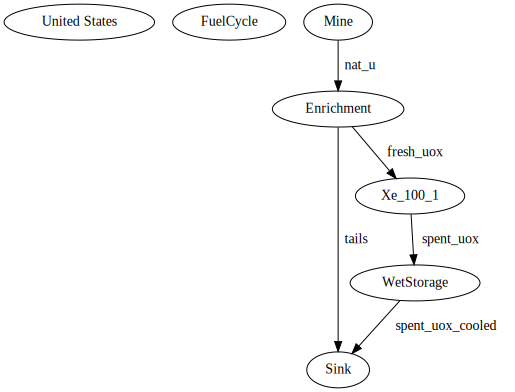

In [10]:
graphs.flow_graph(evaler, label='com')

In [11]:
repository_waste = timeseries.transactions(evaler=evaler, receivers=['Sink'])

Text(0, 0.5, 'Mass of waste [kg]')

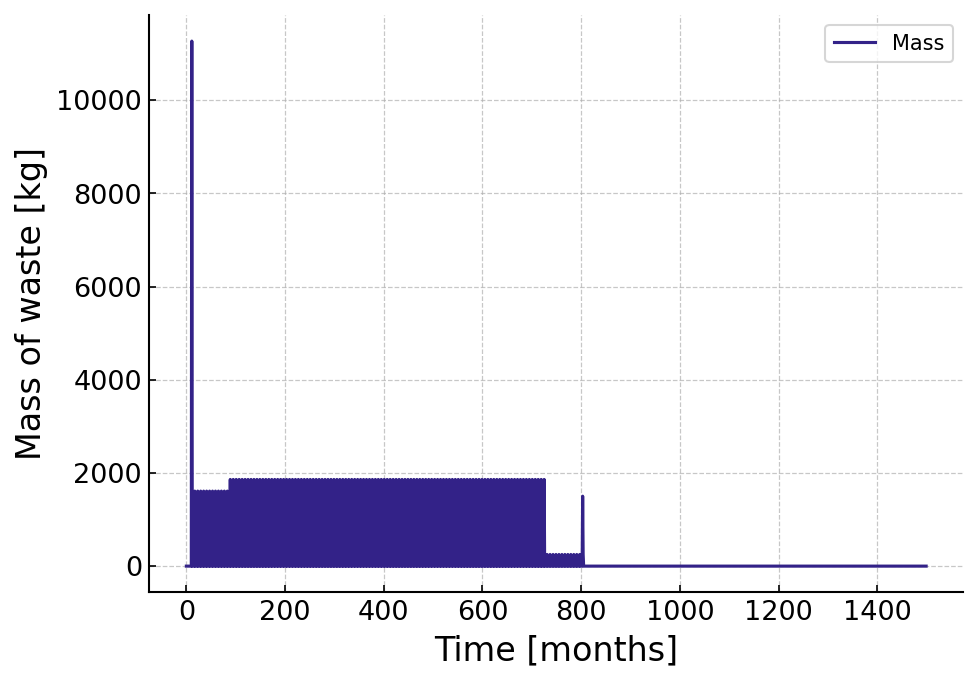

In [12]:
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

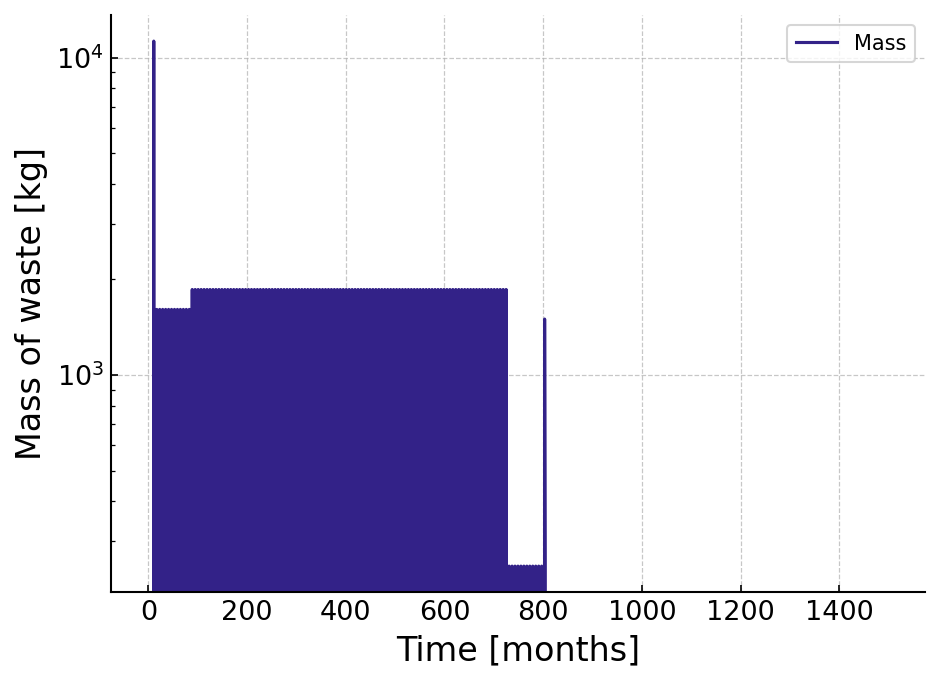

In [13]:
repository_waste.plot(x='Time', logy=True)
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

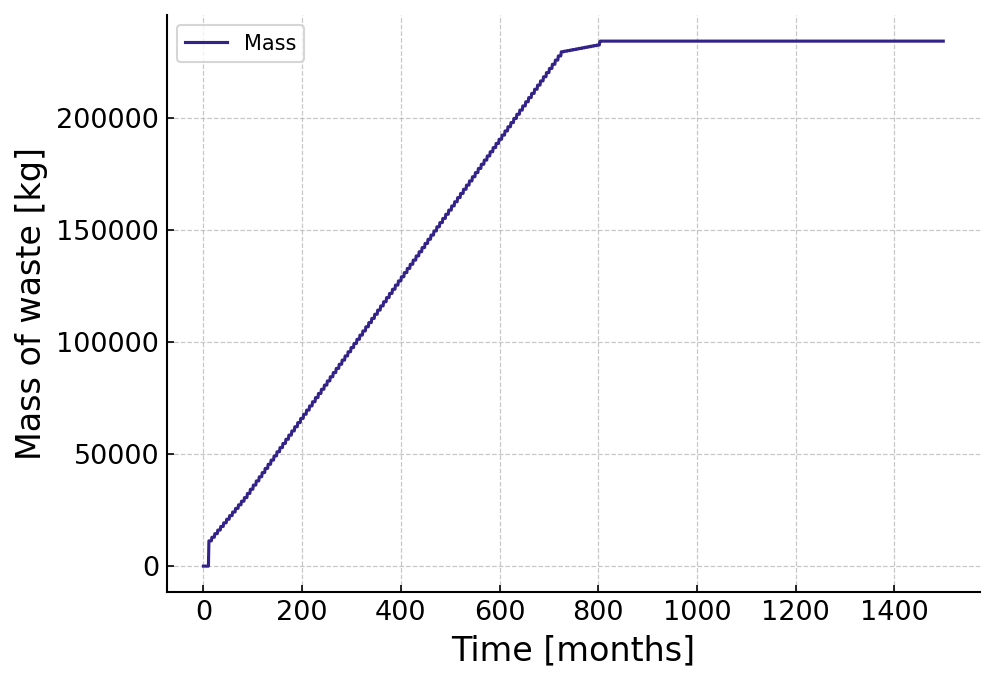

In [14]:
repository_waste['Mass'] = repository_waste['Mass'].cumsum()
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

In [15]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

transactions['spent_uox_total'] = transactions.loc[transactions['Commodity'] == 'spent_uox']['Quantity'].cumsum()
transactions['fresh_uox_total'] = transactions.loc[transactions['Commodity'] == 'fresh_uox']['Quantity'].cumsum()

transactions.ffill(inplace=True)
transactions['total_fuel'] = transactions['spent_uox_total'] + transactions['fresh_uox_total']

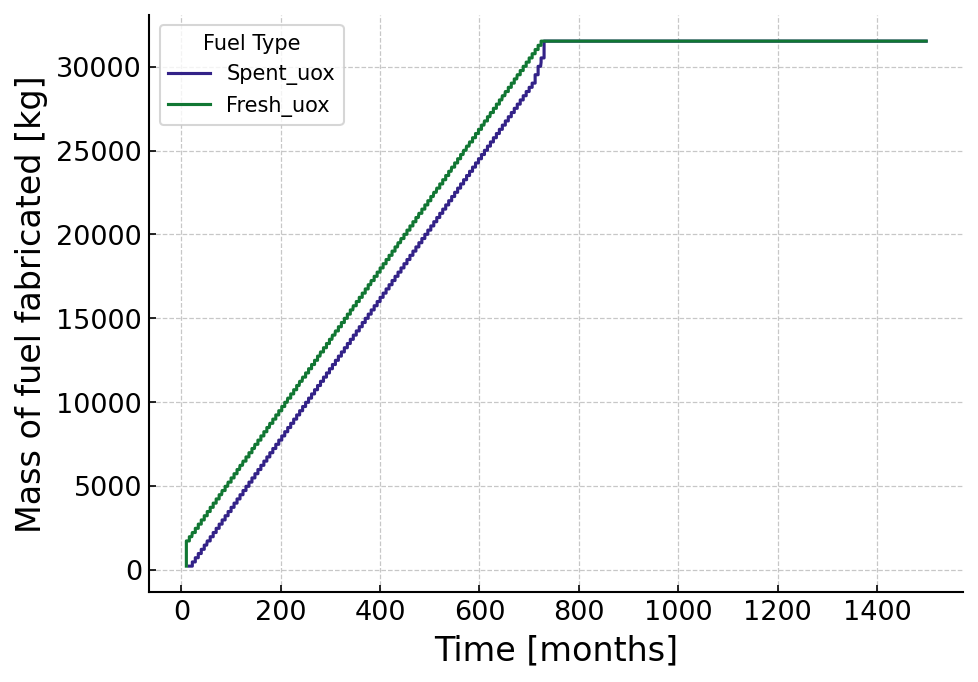

In [16]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'spent_uox_total', 'fresh_uox_total']].plot(x = 'Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of fuel fabricated [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text('Spent_uox')
legend.get_texts()[1].set_text('Fresh_uox')
legend.set_title('Fuel Type')

In [17]:
U235_mass = timeseries.transactions(evaler=evaler, receivers=['Xe_100_1', 'fresh_uox'], nucs=['92235'])
U235_mass['Mass'] = U235_mass['Mass'].cumsum()
U235_mass.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of U235 [kg]')

# Sqlite Analysis
In this section, I will use basic sqlite to generate plots of the remaining data.

In [19]:
conn = sqlite3.connect('single_xe100_out_simple.sqlite')

In [20]:
cursor = conn.cursor()

In [21]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()

In [22]:
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

for row in info_rows:
    print(row)

# define variables for the start and end of the simulation
start_year = info_rows[0][2]
start_month= info_rows[0][3]
end_month = info_rows[0][4]

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', '', 1965, 1, 1500, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [23]:
# now we can add the rest of the dates from the simulation info
dates = pd.date_range(start=f'{start_year}-{start_month}-01', periods=end_month, freq='ME')

In [24]:
cursor.execute("SELECT * FROM DecomSchedule")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 731, 731)


In [25]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 22, 'Xe_100_1', 0, 10)


## Energy Production

In [26]:
# we will pull the decom schedule to see the ids and decomission date, to id the reactor
cursor.execute("SELECT * FROM DecomSchedule")
decom_rows = cursor.fetchall()

for row in decom_rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 731, 731)


In [27]:
# now we will pull the supplied power to get the amount of power from each reactor at every time step
cursor.execute("SELECT * FROM TimeSeriessupplyPOWER")
supply_rows = cursor.fetchall()

#for row in supply_rows:
#    print(row)

In [28]:
# create an empty dictionary that mirrors the format of the powersupply table
energy_supply = {
    'id':[],
    'time':[],
    'energy':[]
}

# now we will pull the power at each time step for each reactor
for row in range(len(supply_rows)):
    energy_supply['id'].append(str(supply_rows[row][1]))
    energy_supply['time'].append(supply_rows[row][2])
    energy_supply['energy'].append(supply_rows[row][3])

In [29]:
# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
energy_supply_df = pd.DataFrame.from_dict(energy_supply)

In [30]:
# we will turn the ids into columns of energy and make the index time
switch_energy_supply = energy_supply_df.pivot_table(index='time', columns='id', values='energy', fill_value=0)

# now we will add a total_energy column
switch_energy_supply['total_energy'] = switch_energy_supply.iloc[:,0:].sum(axis=1)

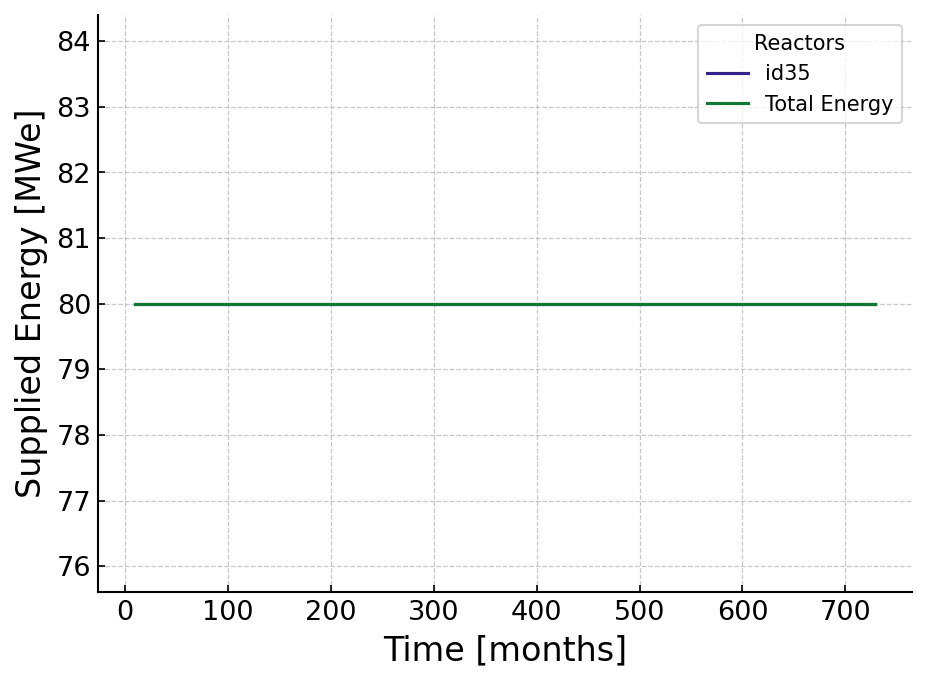

In [31]:
switch_energy_supply[['35','total_energy']].plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('id35')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

In [32]:
simulation_energy_supply = pd.DataFrame(index=range(start_month,end_month), columns=switch_energy_supply.columns)
simulation_energy_supply = simulation_energy_supply.fillna(0)

for column in switch_energy_supply.columns:
    for time in range(min(switch_energy_supply.index), max(switch_energy_supply.index)):
        simulation_energy_supply.loc[time, column] = switch_energy_supply.loc[time, column]

/tmp/ipykernel_17617/2997257727.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  simulation_energy_supply = simulation_energy_supply.fillna(0)


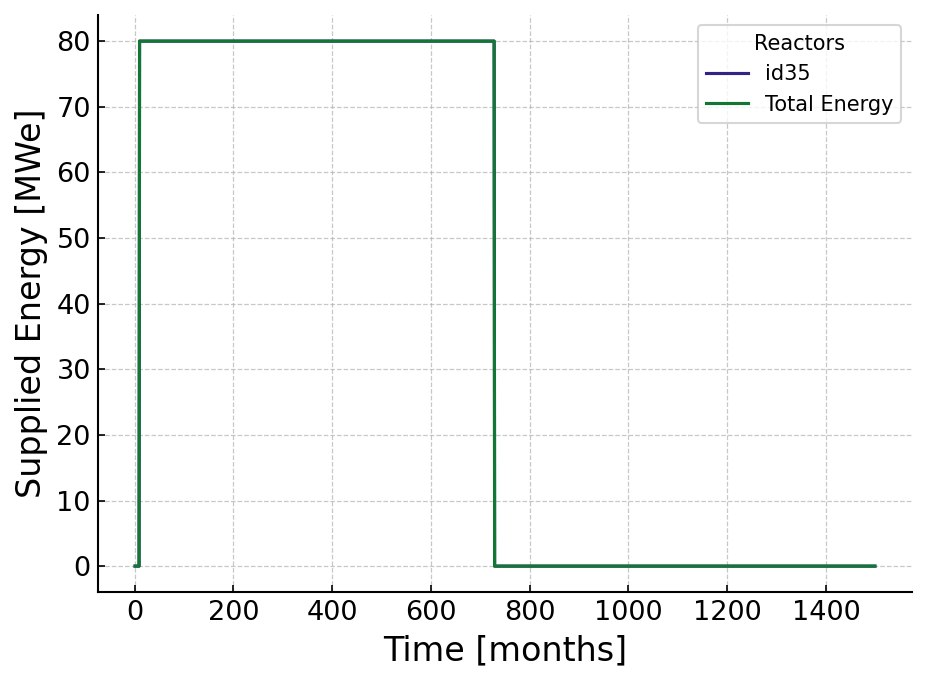

In [33]:
simulation_energy_supply.plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('id35')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

## SWU

In [34]:
cursor.execute("SELECT * FROM TimeSeriesEnrichmentSWU")
swu_rows = cursor.fetchall()

#for row in swu_rows:
#    print(row)

In [35]:
# create an empty dictionary that mirrors the format of the TimeSeriesEnrichmentSWU table
swu_supply = {
    'id':[],
    'Time':[],
    'SWU':[]
}

# now we will pull the swu at each time step for each facility
for row in range(len(swu_rows)):
    swu_supply['id'].append(str(swu_rows[row][1]))
    swu_supply['Time'].append(swu_rows[row][2])
    swu_supply['SWU'].append(swu_rows[row][3])

# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
swu_supply_df = pd.DataFrame.from_dict(swu_supply)

In [36]:
# we will turn the ids into columns of energy and make the index time
switch_swu_supply = swu_supply_df.pivot_table(index='Time', columns='id', values='SWU', fill_value=0)

# now we will add a total_energy column
switch_swu_supply['total_swu'] = switch_swu_supply.iloc[:,0:].sum(axis=1)

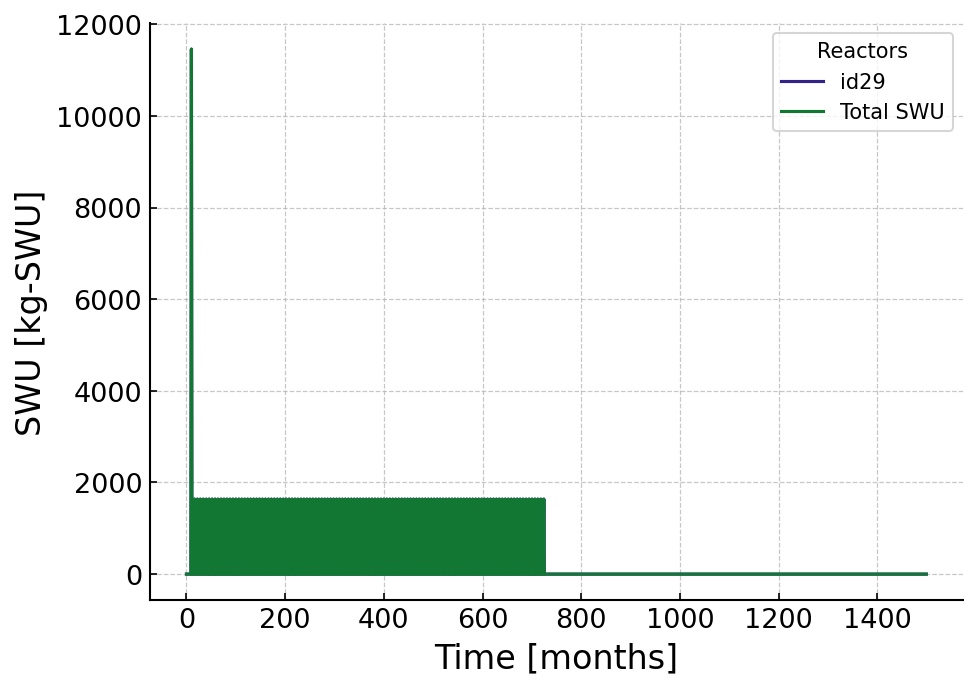

In [37]:
switch_swu_supply[['29','total_swu']].plot()
plt.xlabel('Time [months]')
plt.ylabel('SWU [kg-SWU]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('id29')
legend.get_texts()[1].set_text('Total SWU')
legend.set_title('Reactors')

# Graveyard

In [38]:
cursor.execute("SELECT * FROM TimeSeriesPower")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 10, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 11, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 12, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 13, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 14, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 15, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 17, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 18, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 19, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 20, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 21, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 23, 80.0, '')
(b'\xdb\xb8nm\xb4 D`

In [39]:
cursor.execute("SELECT * FROM AgentStateInventories")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53523)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53529)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53531)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53533)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53535)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53537)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53598)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53600)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53602)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53604)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53606)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53665)
(b'\xdb\xb8nm\xb

In [40]:
cursor.execute("SELECT * FROM Prototypes")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'Xe_100_1', 14, ':cycamore:Reactor')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'Sink', 15, ':cycamore:Sink')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'Mine', 16, ':cycamore:Source')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'Enrichment', 17, ':cycamore:Enrichment')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'WetStorage', 18, ':cycamore:Storage')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'FuelCycle', 19, ':cycamore:DeployInst')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'United States', 20, ':agents:NullRegion')


In [41]:
cursor.execute("SELECT * FROM ReactorEvents")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 10, 'LOAD', '7 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 10, 'CYCLE_START', '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'TRANSMUTE', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'CYCLE_END', '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'DISCHARGE', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'LOAD', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'CYCLE_START', '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'TRANSMUTE', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'CYCLE_END', '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'DISCHARGE', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'LOAD', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'CYCLE_START', '')
(

In [42]:
cursor.execute("SELECT * FROM FieldTypes")
rows = cursor.fetchall()

for row in rows:
    print(row)

('InputFiles', 'SimId', 7)
('InputFiles', 'Data', 6)
('Info', 'SimId', 7)
('Info', 'Handle', 4)
('Info', 'InitialYear', 1)
('Info', 'InitialMonth', 1)
('Info', 'Duration', 1)
('Info', 'Seed', 1)
('Info', 'Stride', 1)
('Info', 'ParentSimId', 7)
('Info', 'ParentType', 4)
('Info', 'BranchTime', 1)
('Info', 'CyclusVersion', 4)
('Info', 'CyclusVersionDescribe', 4)
('Info', 'SqliteVersion', 4)
('Info', 'Hdf5Version', 4)
('Info', 'BoostVersion', 4)
('Info', 'LibXML2Version', 4)
('Info', 'CoinCBCVersion', 4)
('DecayMode', 'SimId', 7)
('DecayMode', 'Decay', 4)
('InfoExplicitInv', 'SimId', 7)
('InfoExplicitInv', 'RecordInventory', 0)
('InfoExplicitInv', 'RecordInventoryCompact', 0)
('TimeStepDur', 'SimId', 7)
('TimeStepDur', 'DurationSecs', 1)
('Epsilon', 'SimId', 7)
('Epsilon', 'GenericEpsilon', 3)
('Epsilon', 'ResourceEpsilon', 3)
('XMLPPInfo', 'SimId', 7)
('XMLPPInfo', 'LibXMLPlusPlusVersion', 4)
('SolverInfo', 'SimId', 7)
('SolverInfo', 'Solver', 4)
('SolverInfo', 'ExclusiveOrders', 0)
('Gre

In [43]:
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

for row in info_rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', '', 1965, 1, 1500, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [44]:
cursor.execute("SELECT * FROM InfoExplicitInv")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 0)


In [45]:
cursor.execute("SELECT * FROM NextIds")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'Agent', 35)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'Transaction', 0)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'Composition', 5)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'ResourceState', 1)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'ResourceObj', 1)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'Product', 1)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'Agent', 36)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'Transaction', 7999)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'Composition', 1763)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'ResourceState', 105505)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'ResourceObj', 93627)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'Product', 1)


In [46]:
columns

[('FieldTypes',),
 ('InputFiles',),
 ('Info',),
 ('DecayMode',),
 ('InfoExplicitInv',),
 ('TimeStepDur',),
 ('Epsilon',),
 ('XMLPPInfo',),
 ('SolverInfo',),
 ('GreedySolverInfo',),
 ('Compositions',),
 ('Recipes',),
 ('AgentStateAgent',),
 ('AgentState_cycamore_ReactorInfo',),
 ('Prototypes',),
 ('AgentVersions',),
 ('AgentState_cycamore_SinkInfo',),
 ('AgentState_cycamore_SourceInfo',),
 ('AgentPosition',),
 ('AgentState_cycamore_EnrichmentInfo',),
 ('AgentState_cycamore_StorageInfo',),
 ('AgentState_cycamore_DeployInstInfo',),
 ('AgentState_agents_NullRegionInfo',),
 ('AgentEntry',),
 ('BuildSchedule',),
 ('Snapshots',),
 ('NextIds',),
 ('TimeSeriesdemandtails',),
 ('TimeSeriesdemandspent_uox_cooled',),
 ('TimeSeriessupplynat_u',),
 ('TimeSeriessupplytails',),
 ('TimeSeriessupplyfresh_uox',),
 ('Resources',),
 ('MaterialInfo',),
 ('ResCreators',),
 ('Transactions',),
 ('TimeSeriesEnrichmentSWU',),
 ('TimeSeriesEnrichmentFeed',),
 ('TimeSeriesdemandnat_u',),
 ('TimeSeriesdemandspent_u

In [47]:


# we'll make an empty dataframe based on this range, which we'll overwrite with the existing data
#simulation_energy_supply = pd.DataFrame(index=dates, columns=switch_energy_supply.columns)

# now we will combine the 
#switch_energy_supply = switch_energy_supply.reindex(simulation_energy_supply.index)

#for col in switch_energy_supply.columns:
#    simulation_energy_supply[col] = switch_energy_supply[col].copy()

# now we can fill the missing values with 0 instead of NaN
#simulation_energy_supply = simulation_energy_supply.fillna(0)